## Notes to myself: to delete later: Want to arrange the cold hands estimate percentage vs player. If we order it by decreasing percentage, does anything obvious pop out (like is cold hands magnitude inversely correlated with player rank? -- could make sense because "better" players get in their heads less.)

## Here we will analyze the tennis data, either the real deal in formatted_data/ , or the mock data that we generated with mock_data_generator.ipynb and saved in formatted_mock_data.

## We want to look at correlations between each service (if the first serve went in, what is the chance it goes in on the next point?).

## For the mock data, we generated two data sets, one with a cold hands magnitude of 10% (if the first serve went out, there is a 10% higher chance that the next first serve will also miss).

## First things first, lets generate our data structure class to hold everything.

In [26]:
import json

class Data(object):
    def __init__(self, serve_data=None):
        self.serve_data = serve_data

    def __getitem__(self, player_id):
        return self.serve_data[player_id]

    @property
    def player_ids(self):
        return list(self.serve_data.keys())

    @classmethod
    def load(cls, path):
        with open(path, 'r') as file:
            serve_data = json.load(file)
        serve_data = {int(key): val for key, val in serve_data.items()} # get rid of the string keys.
        return cls(serve_data)

# first, lets load in the mock data:
case0 = Data.load('formatted_mock_data/cold_hands0.json')
case0p1 = Data.load('formatted_mock_data/cold_hands0p1.json')

Now we can easily pull each set of data for each player as follows, (in the following example, player 0, both for case 0 (no hot/cold hands effect))

In [25]:
print(case0[0][5], 'player 0, set 5')
print(case0[0][30], 'player 0, set 30 (note that we combined all matches sets)')

[1, 1, 0, 0, 1, 1] player 0, set 5
[0, 0, 1, 0, 1, 0] player 0, set 30 (note that we combined all matches sets)


## Now we want to compute 2 conditional probabilities, for each player:
## P(F|LF) where F is missing that serve and LF is a fault on the last service (LF for last-fault). 
## And P(G|LF) : the probability of getting a fault on this serve, given that the last serve was a fault

### In case0, We should recover that P(F|LF) = P(G|LF), because by design, in the mock data, we set this effect to 0.
### in the case0p1, we should recover that P(F|LF) is 0.1 larger than P(G|LF). Because we set that the chance of going in was 10% higher if the last serve went in also.

### So let's go ahead and write a function to estimate those probabilities for a give player.

In [83]:
from astropy.table import Table
import numpy as np

def estimate_conditional_probability(player_serve_data):
    # there is a nuance here that we havent taken into account. pglg is simply more likely, because
    # the sequence [1, 1] is more likely than the sequence [1, 0] because all these players have
    # a higher chance of making a shot 
    num_good_with_good_last_serve = 0
    num_good_with_bad_last_serve = 0
    num_bad_with_bad_last_serve = 0
    num_bad_with_good_last_serve = 0
    total_serves = 0
    total_lg = 0
    total_lf = 0
    for game in player_serve_data:
        for i in range(1, len(game)):
            total_serves += 1
            if game[i-1] == 1:
                total_lg += 1
                if game[i] == 1:
                    num_good_with_good_last_serve += 1
                if game[i] == 0:
                    num_bad_with_good_last_serve += 1
            if game[i-1] == 0:
                total_lf += 1
                if game[1] == 1:
                    num_good_with_bad_last_serve += 1
                if game[1] == 0:
                    num_bad_with_bad_last_serve += 1
    pglg = num_good_with_good_last_serve / total_lg
    pglf = num_good_with_bad_last_serve / total_lf
    pflg = num_bad_with_good_last_serve / total_lg
    pflf = num_bad_with_bad_last_serve / total_lf
    pg_avg = (num_good_with_good_last_serve + num_good_with_bad_last_serve)/total_serves
    pf_avg = (num_bad_with_good_last_serve + num_bad_with_bad_last_serve)/total_serves
    return pglg, pglf, pflg, pflf

result = estimate_conditional_probability(case0[0])
print(result)
result = estimate_conditional_probability(case0p1[0])
print(result)

(0.3609967497291441, 0.19869989165763813, 0.23943661971830985, 0.20086673889490791)
(0.3486457204767064, 0.176273022751896, 0.2210184182015168, 0.2540628385698808)


# Now we want to estimate this for every player.

In [84]:
def estimate_conditional_probabilities_all_players(case: Data) -> Table:
    statistics = {'player_id': [], 'pglf': [], 'pglg': [], 'pflg': [], 'pflf': []}
    for player_id in case.player_ids:
        pglg, pglf, pflg, pflf = estimate_conditional_probability(case[player_id])
        statistics['pglf'].append(pglf)
        statistics['pglg'].append(pglg)
        statistics['pflg'].append(pflg)
        statistics['pflf'].append(pflf)
        statistics['player_id'].append(player_id)
    return Table(statistics)

case0_statistics = estimate_conditional_probabilities_all_players(case0)
case0p1_statistics = estimate_conditional_probabilities_all_players(case0p1)

## And then plot the difference between P(G|LG) and P(G|LF) for every player, which by design was defined as a constant (but may not be the case with real data). Case 0 should have this value centered around 0, and case 0p1 should have this centered around 0.1

0.17648901254857072
-0.027418232815966656
0.15908331286739275
0.04091619386975096


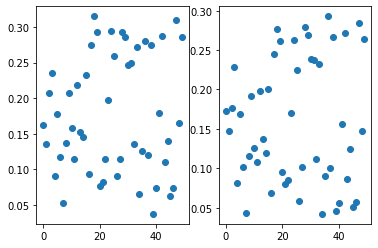

In [85]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
for i, case in enumerate([case0_statistics, case0p1_statistics]):
    axes[i].scatter(case['player_id'], case['pglg'] - case['pglf'])
    print(np.mean(case['pglg'] - case['pglf']))
    print(np.mean(case['pflf'] - case['pflg']))
plt.show()

## OK so per player, we have single estimates that seem to indicate that there is a hot/cold hands effect in the mock data. Single values like 0.11, 0.9, ... etc.. That is good, but we can't really say anything yet. We dont have error bars on the points! So we really want an estimate of how well we know those single values. We want a posterior --> something that tells us: player 0 has a hot hands effect of 0.1 +- 0.02 . Then we can say that the hot hands effect exists with 5 sigma confidence (for that player).

## To get a confidence interval, we are going to use something called bootstrap resampling. This is a way to estimate posteriors from a single set of data, provided that dataset is large enough. Because each player has about 

In [ ]:
def boostrap_estimate_conditional_probabilities(player_serve_data, num_resamples=1000)
    num_sets = len(player_serve_data)
    indices = np.arange(num_sets)
    pglg_samples, pglf_samples = [], []
    for i in range(num_resamples):
        this_sample = np.random.choice(indices, size=len(indices), replace=True)
        player_serve_data_sample = [player_serve_data[i] for i in this_sample]
        pglg, pglf = estimate_conditional_probability(player_serve_data_sample)
        pglg_samples.append(pglg)
        pglf_samples.append(pglf)